In [1]:
import numpy as onp

import jax.numpy as jnp
from jax import random
from jax import jit, grad, vmap, value_and_grad
from jax import lax
from jax import ops

from jax.config import config
config.update("jax_enable_x64", True)

from jax_md import space, smap, energy, minimize, quantity, simulate, partition, util

from functools import partial
import time
from typing import List

f32 = jnp.float32
f64 = jnp.float64
Array = jnp.ndarray

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

def format_plot(x, y):  
  plt.grid(True)
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)
  
def finalize_plot(shape=(1, 0.7)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1], 
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

def calculate_bond_data(displacement_or_metric, R, dr_cutoff, species=None):
  if( not(species is None)):
    assert(False)
    
  metric = space.map_product(space.canonicalize_displacement_or_metric(displacement))
  dr = metric(R,R)

  dr_include = jnp.triu(jnp.where(dr<dr_cutoff, 1, 0)) - jnp.eye(R.shape[0],dtype=jnp.int32)
  index_list=jnp.dstack(jnp.meshgrid(jnp.arange(N), jnp.arange(N), indexing='ij'))

  i_s = jnp.where(dr_include==1, index_list[:,:,0], -1).flatten()
  j_s = jnp.where(dr_include==1, index_list[:,:,1], -1).flatten()
  ij_s = jnp.transpose(jnp.array([i_s,j_s]))

  bonds = ij_s[(ij_s!=jnp.array([-1,-1]))[:,1]]
  lengths = dr.flatten()[(ij_s!=jnp.array([-1,-1]))[:,1]]

  return bonds, lengths

def plot_system(R,box_size,species=None,ms=20):
  R_plt = onp.array(R)

  if(species is None):
    plt.plot(R_plt[:, 0], R_plt[:, 1], 'o', markersize=ms)
  else:
    for ii in range(jnp.amax(species)+1):
      Rtemp = R_plt[species==ii]
      plt.plot(Rtemp[:, 0], Rtemp[:, 1], 'o', markersize=ms)

  plt.xlim([0, box_size])
  plt.ylim([0, box_size])
  plt.xticks([], [])
  plt.yticks([], [])

  finalize_plot((1,1))
  
key = random.PRNGKey(0)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
2022-05-31 15:19:57.340970: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


Knots and coefficients from the tungsten 2-body example

In [2]:
from uf3.representation import bspline
from uf3.data import composition
from uf3.regression import least_squares

element_list = ['W']
degree = 2

chemical_system = composition.ChemicalSystem(element_list=element_list,
                                             degree=degree)

r_min_map = {('W', 'W'): 1.5,
            }
r_max_map = {('W', 'W'): 5.5,
            }
resolution_map = {('W', 'W'): 25,
                 }
trailing_trim = 3

bspline_config = bspline.BSplineBasis(chemical_system,
                                      r_min_map=r_min_map,
                                      r_max_map=r_max_map,
                                      resolution_map=resolution_map,
                                      trailing_trim=trailing_trim)

model = least_squares.WeightedLinearModel(bspline_config)

model.load(filename="../tungsten_extxyz/model_pair.json")

In [3]:
coefficients = jnp.asarray(model.coefficients[1:])
knots = jnp.asarray(model.bspline_config.knots_map[('W','W')])

print(coefficients)
print(knots)

[ 6.43001157e+00  5.97354258e+00  5.06058796e+00  3.69113106e+00
  1.65205855e+00  9.23859147e-01  2.81258202e-01 -5.36413561e-03
 -1.65669972e-01 -2.39954884e-01 -2.77954263e-01 -2.80998799e-01
 -2.49653066e-01 -1.77409590e-01 -1.00099852e-01 -6.82599769e-02
 -2.00034440e-02 -3.28071234e-02 -3.43219435e-02 -3.43618259e-02
 -2.88400639e-02 -2.12175439e-02 -6.90983500e-04 -9.25139031e-03
 -8.08694792e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00]
[1.5  1.5  1.5  1.5  1.66 1.82 1.98 2.14 2.3  2.46 2.62 2.78 2.94 3.1
 3.26 3.42 3.58 3.74 3.9  4.06 4.22 4.38 4.54 4.7  4.86 5.02 5.18 5.34
 5.5  5.5  5.5  5.5 ]


In [4]:
from uf3.jax.potentials import uf2_interaction


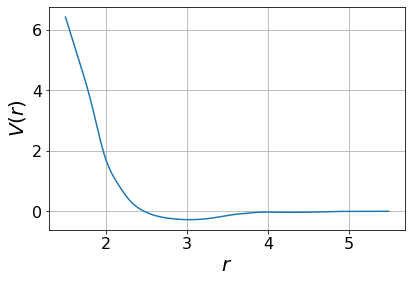

In [5]:
drs = jnp.arange(1.5,5.5,0.01)
U = uf2_interaction(drs, coefficients=coefficients, knots=knots, cutoff=5.5)
plt.plot(drs,U)
format_plot(r'$r$', r'$V(r)$')
finalize_plot()

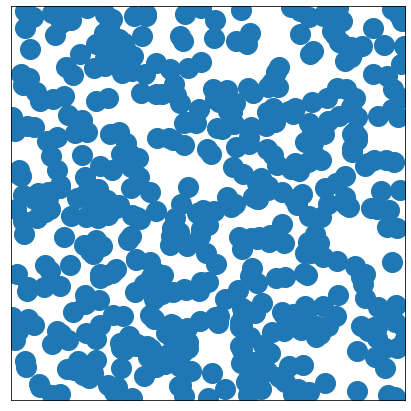

In [6]:
N = 500
dimension = 3
box_size = 12.0

key, split = random.split(key)
R = random.uniform(split, (N,dimension), minval=0.0, maxval=box_size, dtype=f64) 

plot_system(R,box_size)

In [7]:
def setup_periodic_box(box_size):
  def displacement_fn(Ra, Rb, **unused_kwargs):
    dR = Ra - Rb
    return jnp.mod(dR + box_size * f32(0.5), box_size) - f32(0.5) * box_size

  def shift_fn(R, dR, **unused_kwargs):
    return jnp.mod(R + dR, box_size)

  return displacement_fn, shift_fn
  
# displacement, shift = setup_periodic_box(box_size)
box = jnp.eye(dimension) * box_size
displacement, shift = space.periodic_general(box, fractional_coordinates=False)

In [8]:
from uf3.jax.potentials import uf2_pair, get_stress_fn

In [9]:
# Create a function to calculate the total energy with specified parameters
energy_fn = uf2_pair(displacement, coefficients=coefficients, knots=knots)
# energy_fn = uf2(displacement)

# Use this to calculate the total energy
print(energy_fn(R))

ener = lambda c: energy_fn(R, coefficients=c)
print(ener(coefficients))

# Use grad to calculate the net force
force = -grad(energy_fn)(R)
print(force[:5])

forc = grad(ener)(coefficients)
print(forc)

4033.100798646419
4033.100798646419
[[  7.64623469 -10.98462509 -23.73895001]
 [  4.39279262  13.44039394  19.71655208]
 [ 13.82819561 -21.79921483  -5.14190699]
 [ 24.41905083   7.88597327  15.34640167]
 [  1.88079223  -5.52988133  16.91941324]]
[  80.18667359  184.06035033  316.04001647  490.2298231   569.86425275
  658.16960725  754.12424823  861.5019516  1035.36599478 1167.34641746
 1289.49048642 1424.14195878 1550.48454773 1704.94896464 1869.11938022
 2008.97694181 2208.02549203 2397.55218936 2584.83031618 2794.22724524
 2898.8789498  3090.58207582 3351.66114224 3618.73642567 3867.03294737
 3072.65634724 2139.73393779 1092.0313161 ]


In [10]:
stress_fn = get_stress_fn(energy_fn, box)
stress = stress_fn(R)
print(stress)

[[-6.01871806  0.05254257 -0.01569138]
 [ 0.05254257 -6.10154324  0.10966728]
 [-0.01569138  0.10966728 -6.31664028]]


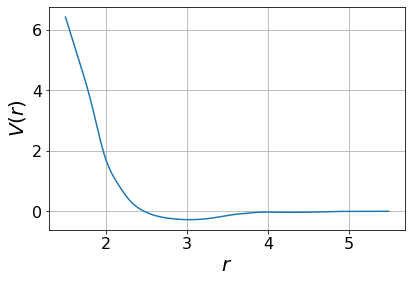

In [11]:
drs = jnp.arange(1.5,5.5,0.01)
U = uf2_interaction(drs, coefficients=coefficients, knots=knots)
plt.plot(drs,U)
format_plot(r'$r$', r'$V(r)$')
finalize_plot()

In [12]:
from jax_md.energy import lennard_jones

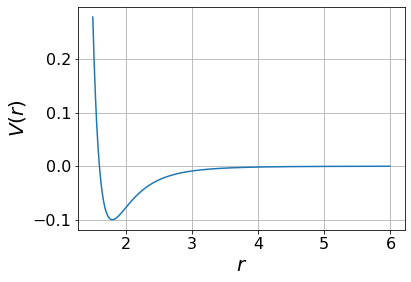

In [13]:
drs = jnp.arange(1.5,6.0,0.01)
U = lennard_jones(drs, sigma=1.6, epsilon=0.1)
plt.plot(drs,U)
format_plot(r'$r$', r'$V(r)$')
finalize_plot()

In [14]:
uf2 = lambda drs, co: uf2_interaction(drs, coefficients=co, knots=knots, cutoff=5.5)
lj = lambda drs: lennard_jones(drs, sigma=1.6, epsilon=0.1)

def error(coefficients):
    return jnp.sum((lj(drs) - uf2(drs, coefficients)) ** 2) / len(drs)


In [15]:
c = jnp.ones_like(coefficients)

grad(error)(c)

DeviceArray([0.01646755, 0.03442659, 0.0565419 , 0.07754003, 0.0767849 ,
             0.07527422, 0.07403187, 0.07314747, 0.07254141, 0.07212836,
             0.07184491, 0.07164809, 0.07150955, 0.07141066, 0.07133909,
             0.07128662, 0.07124767, 0.07121842, 0.0711962 , 0.07117917,
             0.07116598, 0.07115567, 0.07114756, 0.07114111, 0.07113596,
             0.05334939, 0.03549569, 0.01562894], dtype=float64)

0.0013452790854316316
0.0006278917227223336
0.00036913915390466884
0.0002491905801963392
0.00017985624357809253
0.0001340006447162214
0.00010157059537398201
7.78735183453227e-05
6.024249633132021e-05
4.696588792460364e-05


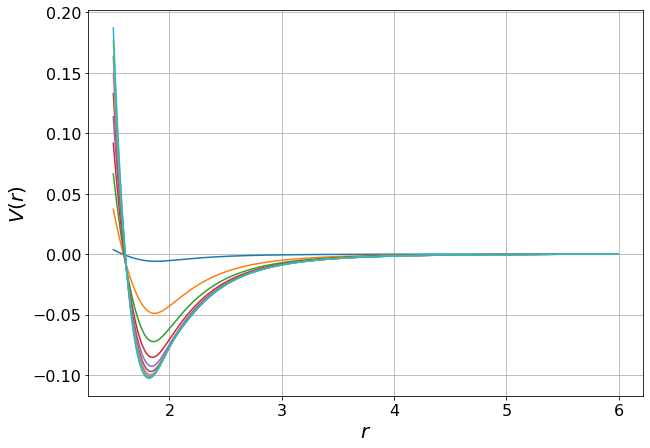

In [16]:
c = jnp.zeros_like(coefficients)
err_fn = jit(grad(error))
err = jit(error)
uf2 = jit(uf2)

for i in range(100):
    dc = err_fn(c)
    c -= dc

    if i % 10 == 0:
        print(err(c))
        U = uf2(drs, c)
        plt.plot(drs,U)
        format_plot(r'$r$', r'$V(r)$')
        finalize_plot()

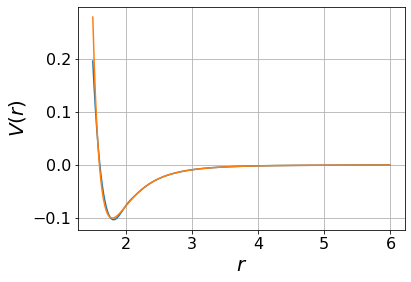

In [17]:
#c = c.at[-3:].set(0.0)
U = uf2(drs, c)
plt.plot(drs,U)
U = lennard_jones(drs, sigma=1.6, epsilon=0.1)
plt.plot(drs,U)
format_plot(r'$r$', r'$V(r)$')
finalize_plot()

In [18]:
print(error(c))

3.7765142082647997e-05


In [19]:
print(c)

[ 1.95714709e-01  5.93088531e-02 -8.21969261e-02 -1.14714095e-01
 -7.69949585e-02 -5.69730341e-02 -3.93616512e-02 -2.73003812e-02
 -1.92354699e-02 -1.37170726e-02 -9.92533790e-03 -7.28590972e-03
 -5.42185978e-03 -4.08697251e-03 -3.11800516e-03 -2.40553170e-03
 -1.87526063e-03 -1.47607917e-03 -1.17236086e-03 -9.38979821e-04
 -7.57920448e-04 -6.16070096e-04 -5.05854050e-04 -4.12002462e-04
 -3.49315861e-04 -2.87373116e-04 -2.59435589e-04 -1.60981312e-04]
